In [1]:
#import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas_profiling
from pandas_profiling.utils.cache import cache_file
from pathlib import Path

In [2]:
#set seed for reproducibility
random.seed(72)

# Dataset Description and Overview
The Synthetic Financial Dataset for Fraud Detection was prepared by a team of computer scientists at the Blekinge Institute of Technology and The Norwegian University of Science and Technology to realistically approximate fraudulent transactions occurring in a real African mobile money transfer service. The high-fidelity reproduction of the dataset means that originator and recipient names, transaction amount monetary units, and dates have been anonymized. For instance, there is no reference date for the month-long period of transactions, but rather only hourly units (steps). 

In [3]:
#import data
#original data set hosted on Kaggle at https://www.kaggle.com/ntnu-testimon/paysim1 
#for detailed overview of dataset see conference paper at https://www.researchgate.net/publication/313138956_PAYSIM_A_FINANCIAL_MOBILE_MONEY_SIMULATOR_FOR_FRAUD_DETECTION 
#all data contained in a single downloaded CSV file
fraud_detection = pd.read_csv('../data/PS_20174392719_1491204439457_log.csv')

In [4]:
#explore data
fraud_detection.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
#rows and columns
fraud_detection.shape

(6362620, 11)

In [5]:
#explore data info
fraud_detection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
#describe
fraud_detection.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


# Initial Findings
The dataset consists of approximately 6.4M transactions each with 11 fields. All numeric amounts (e.g., amount, oldbalanceOrg, oldbalanceDest) all are consistently numeric (float64). The label variable, isFraud, takes values 0 or 1 and has a mean of 1.29E-3 telling us that only about 1/1000 transactions are fraudulent. Interestingly, isFlaggedFraud is only about a 1 in 400,000 event. According to the dataset overview, isFlaggedFraud is an attempt by the company to detect fraud by flagging transactions of over 200,000 monetary units. 

In [ ]:
#pandas profiling for EDA
#please see fraud_money_transfer.html flie for details
profile_report = fraud_detection.profile_report(html={'style': {'full_width': True}})
profile_report.to_file("profile_EDA/fraud_money_transfer.html")

# Pandas Profiling Highlights
The Pandas Profile shows no missing values or any extreme outliers. Furthermore, both the sender’s name is 99.9% unique whereas the recipient is only 42.8% unique, meaning that there are many customers are sending money to comparatively few recipients. The transaction amounts and balances are highly right skewed. Interestingly, some of the transaction amounts are 0. 

In [7]:
#how many transaction amounts are zero?
zero_amnts = fraud_detection[fraud_detection.amount == 0]
zero_amnts.shape[0]

16

In [8]:
#is there any pattern or interesting information on the zero transaction amounts?
zero_amnts

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736447,212,CASH_OUT,0.0,C1510987794,0.0,0.0,C1696624817,0.00,0.00,1,0
3247298,250,CASH_OUT,0.0,C521393327,0.0,0.0,C480398193,0.00,0.00,1,0
3760289,279,CASH_OUT,0.0,C539112012,0.0,0.0,C1106468520,538547.63,538547.63,1,0
5563714,387,CASH_OUT,0.0,C1294472700,0.0,0.0,C1325541393,7970766.57,7970766.57,1,0
5996408,425,CASH_OUT,0.0,C832555372,0.0,0.0,C1462759334,76759.90,76759.90,1,0
5996410,425,CASH_OUT,0.0,C69493310,0.0,0.0,C719711728,2921531.34,2921531.34,1,0
6168500,554,CASH_OUT,0.0,C10965156,0.0,0.0,C1493336195,230289.66,230289.66,1,0
6205440,586,CASH_OUT,0.0,C1303719003,0.0,0.0,C900608348,1328472.86,1328472.86,1,0
6266414,617,CASH_OUT,0.0,C1971175979,0.0,0.0,C1352345416,0.00,0.00,1,0
6281483,646,CASH_OUT,0.0,C2060908932,0.0,0.0,C1587892888,0.00,0.00,1,0


All records with a zero transaction amount are fradulent, although none have been flagged as such (since only transactions greater than 200K are flagged as fradulent). Also, the origin balances always start and end at 0. These zero transactions seem anomalous, and since they represent no loss to the company, I will exclude them from the dataset.

From our initial analysis, the Fraud Detection dataset consists of approximately 6.36M rows and 11 columns. Two possible labels include isFraud and isFlaggedFraud, where the former is whether the transaction was actually fraudulent and the latter whether the transaction was flagged as fraudulent. Interestingly, the mean of isFraud is approximately 400x greater than isFlaggedFraud, indicating that much of the fraud is not detected.

In [9]:
#split data into Fraud and Non-fraud and get rid of zero amounts (for now)
Fraud_data = fraud_detection[(fraud_detection['isFraud']==1) & (fraud_detection['amount']>0)]
Non_fraud_data = fraud_detection[fraud_detection['isFraud']==0]
Fraud_data.shape[0], Non_fraud_data.shape[0]

(8197, 6354407)

In [10]:
#are there any cases where transaction amount exceeds the balance prior to the transfer?
fraud_detection[(fraud_detection.amount > fraud_detection.oldbalanceOrg)]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
8,1,PAYMENT,4024.36,C1265012928,2671.0,0.0,M1176932104,0.00,0.00,0,0
10,1,DEBIT,9644.94,C1900366749,4465.0,0.0,C997608398,10845.00,157982.12,0,0
13,1,PAYMENT,11633.76,C1716932897,10127.0,0.0,M801569151,0.00,0.00,0,0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.00,51513.44,0,0
16,1,PAYMENT,1563.82,C761750706,450.0,0.0,M1731217984,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362316,718,PAYMENT,1022.91,C1203084509,12.0,0.0,M675916850,0.00,0.00,0,0
6362317,718,CASH_OUT,317177.48,C857156502,170.0,0.0,C784108220,345042.13,662219.61,0,0
6362320,718,CASH_OUT,159188.22,C691808084,3859.0,0.0,C1818183087,0.00,159188.22,0,0
6362321,718,CASH_OUT,186273.84,C102120699,168046.0,0.0,C1515639522,24893.67,211167.51,0,0


In [11]:
c1_step1=fraud_detection[((fraud_detection['nameOrig']=='C997608398')|(fraud_detection['nameDest']=='C997608398'))&(fraud_detection.step==1)]
c1_step1

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
10,1,DEBIT,9644.94,C1900366749,4465.00,0.00,C997608398,10845.00,157982.12,0,0
781,1,TRANSFER,345698.98,C1453062635,40419.00,0.00,C997608398,20489.94,157982.12,0,0
807,1,DEBIT,1741.24,C1687627235,80942.00,79200.76,C997608398,366188.92,157982.12,0,0
861,1,CASH_OUT,155122.86,C1403716230,0.00,0.00,C997608398,367930.17,157982.12,0,0
925,1,CASH_OUT,251241.14,C1636178473,25534.61,0.00,C997608398,523053.03,157982.12,0,0
1360,1,CASH_OUT,286803.50,C1481751887,0.00,0.00,C997608398,774294.17,157982.12,0,0
1395,1,TRANSFER,70543.76,C1964926542,80351.55,9807.80,C997608398,1061097.67,157982.12,0,0
1706,1,CASH_IN,235362.23,C220432328,2073267.50,2308629.73,C997608398,1128757.61,157982.12,0,0
1718,1,CASH_IN,532111.14,C109065770,4244257.62,4776368.76,C997608398,893395.39,157982.12,0,0
1854,1,CASH_OUT,63557.19,C1093441885,0.00,0.00,C997608398,361284.25,157982.12,0,0


In [12]:
fraud_detection[((fraud_detection['nameOrig']=='C997608398')|(fraud_detection['nameDest']=='C997608398'))]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
10,1,DEBIT,9644.94,C1900366749,4465.00,0.00,C997608398,10845.00,157982.12,0,0
781,1,TRANSFER,345698.98,C1453062635,40419.00,0.00,C997608398,20489.94,157982.12,0,0
807,1,DEBIT,1741.24,C1687627235,80942.00,79200.76,C997608398,366188.92,157982.12,0,0
861,1,CASH_OUT,155122.86,C1403716230,0.00,0.00,C997608398,367930.17,157982.12,0,0
925,1,CASH_OUT,251241.14,C1636178473,25534.61,0.00,C997608398,523053.03,157982.12,0,0
1360,1,CASH_OUT,286803.50,C1481751887,0.00,0.00,C997608398,774294.17,157982.12,0,0
1395,1,TRANSFER,70543.76,C1964926542,80351.55,9807.80,C997608398,1061097.67,157982.12,0,0
1706,1,CASH_IN,235362.23,C220432328,2073267.50,2308629.73,C997608398,1128757.61,157982.12,0,0
1718,1,CASH_IN,532111.14,C109065770,4244257.62,4776368.76,C997608398,893395.39,157982.12,0,0
1854,1,CASH_OUT,63557.19,C1093441885,0.00,0.00,C997608398,361284.25,157982.12,0,0


From the above analysis, we notice that the newbalance only updates after each step (hour) in the dataset whereas the oldbalance is updated with each transaction. Therefore, individual fraudulent transactions may not be best detected with newbalance.

In terms of the transaction types, we are given (see https://www.researchgate.net/publication/313138956_PAYSIM_A_FINANCIAL_MOBILE_MONEY_SIMULATOR_FOR_FRAUD_DETECTION) that:

	• CASH-IN is the process of increasing the balance of account by paying in cash to a merchant.
	• CASH-OUT is the opposite process of CASH-IN, it means to withdraw cash from a merchant which decreases the balance of the account.
	• DEBIT is similar process than CASH-OUT and involves sending the money from the mobile money service to a bank account.
	• PAYMENT is the process of paying for goods or services to merchants which decreases the balance of the account and increases the balance of the receiver.
    • TRANSFER is the process of sending money to another user of the service through the mobile money platform!

Therefore, for the sender, CASH-IN increases their account balance whereas CASH-OUT, DEBIT, PAYMENT, and TRANSFER decrease the balance. The opposite is true from the recipient.

In [13]:
#checking whether the sums match up to account balance for a single step for recipient'nameDest'=='C997608398'
starting_balance = c1_step1.loc[:,'oldbalanceDest'].iloc[0]
c1_step1_signed = c1_step1.copy()
c1_step1_signed = c1_step1_signed.assign(amount = np.select([c1_step1_signed['type']=='CASH_IN'], [-1 * c1_step1_signed['amount']],c1_step1_signed['amount']))
c1_step1_signed['amount'].sum() + starting_balance, c1_step1.loc[:,'newbalanceDest'].iloc[0]

(160865.92999999996, 157982.12)

It looks like the individual transactions do not quite add up the the account balance. There are two potential reasons for this: (1) the Kaggle dataset is only 1/4 of the original dataset, and depending on how the data was chosen it may not have included all transactions from each customer included in this scaled down version. However, I don't think this is likely. Another reason is that even the full data set does not include all transaction types. There may, for example, be a transfer fee transaction that would not show up in this data set and lead to discrepancies in the transaction amounts and final account balances.

Another notable point is that names starting with "M" are merchants and their account balances are not recorded in the dataset.

From the above analysis, we notice that the newbalance only updates after each step (hour) in the dataset whereas the oldbalance is updated with each transaction. Therefore, individual fraudulent transactions may not be best detected with newbalance.

In [14]:
#function for calculating balance discrepancies
def balance_discrepancy(dfg):
    starting_balance = dfg.loc[:,'oldbalanceDest'].iloc[0]
    end_balance = dfg.loc[:,'newbalanceDest'].iloc[0]
    dfg = dfg.assign(amount = np.select([dfg['type']=='CASH_IN'], [-1 * dfg['amount']],dfg['amount']))
    final_balance = dfg['amount'].sum() + starting_balance
    if end_balance == final_balance:
        return(1)
    if end_balance == 0:
        end_balance = end_balance + 0.01
    ratio = final_balance/end_balance
    return(ratio) #,dfg['step'])

In [15]:
#sampel first step for balance discrepancies. Look only for customers (nameDest starts with C) since merchants do not have account balances stored
ratio_balance = fraud_detection[(fraud_detection.step == 1) & (fraud_detection.nameDest.str.contains('C'))].groupby(['step','nameDest']).apply(balance_discrepancy)
ratio_balance

step  nameDest   
1     C100555887     1.000000e+00
      C1007251739    2.900800e+06
      C101601906     1.000000e+00
      C1018298342    1.000000e+00
      C1023714065    1.000000e+00
                         ...     
      C985934102     1.473066e+00
      C990355670     1.000000e+00
      C990398217     1.103614e+00
      C997608398     1.018254e+00
      C998351292     6.712070e-01
Length: 264, dtype: float64

In [16]:
ratio_balance.describe()

count    2.640000e+02
mean     1.638046e+06
std      1.208285e+07
min     -3.143646e+07
25%      1.000000e+00
50%      1.193472e+00
75%      4.711877e+03
max      1.285739e+08
dtype: float64

In [17]:
#look at one particular case where balance ratio is far from 1.
fraud_detection[(fraud_detection.nameDest == 'C1100439041') & (fraud_detection.step == 1)]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
19,1,TRANSFER,215310.30,C1670993182,705.00,0.00,C1100439041,22425.00,0.0,0,0
416,1,CASH_IN,63255.29,C632475595,4904890.21,4968145.50,C1100439041,237735.30,0.0,0,0
457,1,CASH_IN,142577.44,C727197178,1601450.63,1744028.07,C1100439041,174480.01,0.0,0,0


Although the transaction amounts do not sum up to the new balance, this issue may not impact fraud detection because we are only attempting to flag individual events and in this dataset. This hold especially true if fraudsters commmit very few transactions before retiring their account.

In [18]:
#check statistics on the fraudulent transactions
Fraud_data[['nameOrig','nameDest']].value_counts().max(), Fraud_data['nameOrig'].value_counts().max(),Fraud_data['nameDest'].value_counts().max()

(1, 1, 2)

In [19]:
Fraud_data['nameDest'].value_counts().describe()

count    8154.000000
mean        1.005273
std         0.072431
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: nameDest, dtype: float64

There are no fraudulent transactions occuring more than once between two parties, and in no case is the sender part of a fraudulent transaction more than once. The recipient is at most part of two fraudulent transactions, but the mean is very close to one transaction.

# Initial EDA

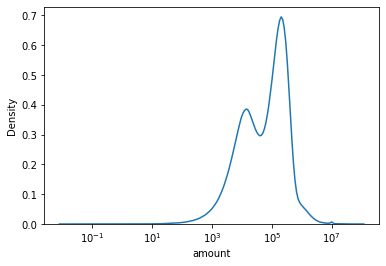

In [20]:
#this takes about 30 seconds...
full_data_kde = sns.kdeplot(data=Non_fraud_data.amount, log_scale=True)
plt.show()

It is cumbersome to use all the data included in the set for observing general trends. Take a sample of non-fraud equal to the fraudulent observations.

In [21]:
Non_fraud_data_sample = Non_fraud_data.sample(n=Fraud_data.shape[0])
Non_fraud_data_sample.shape

(8197, 11)

In [22]:
balanced_data_sample = pd.concat([Non_fraud_data_sample,Fraud_data])
balanced_data_sample.shape

(16394, 11)

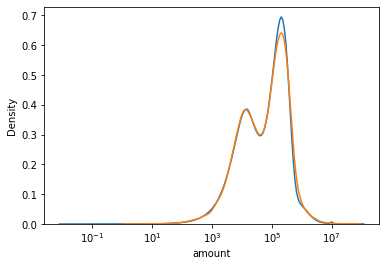

In [23]:
full_data_kde = sns.kdeplot(data=Non_fraud_data.amount, log_scale=True)
sample_data_kde = sns.kdeplot(data=Non_fraud_data_sample.amount, log_scale=True)
plt.show()

Very similar trends between sample and population data! Let's combine the fraud and non-fraud sample data into one set.

In [24]:
eda_data = Non_fraud_data_sample.append(Fraud_data)
eda_data.shape

(16394, 11)

<AxesSubplot:xlabel='amount', ylabel='Density'>

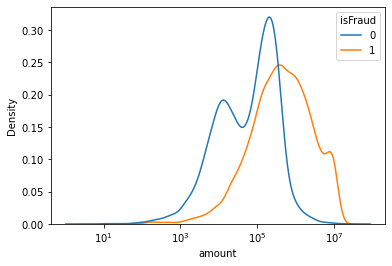

In [25]:
sns.kdeplot(data = eda_data, x='amount',hue='isFraud',log_scale=True)

The amount of the fraudulent transactions does not show the same bimodality and has a lower mean.

In [26]:
balance_subset_cols = balanced_data_sample[['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud']]

C:\Users\bwitt\Anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


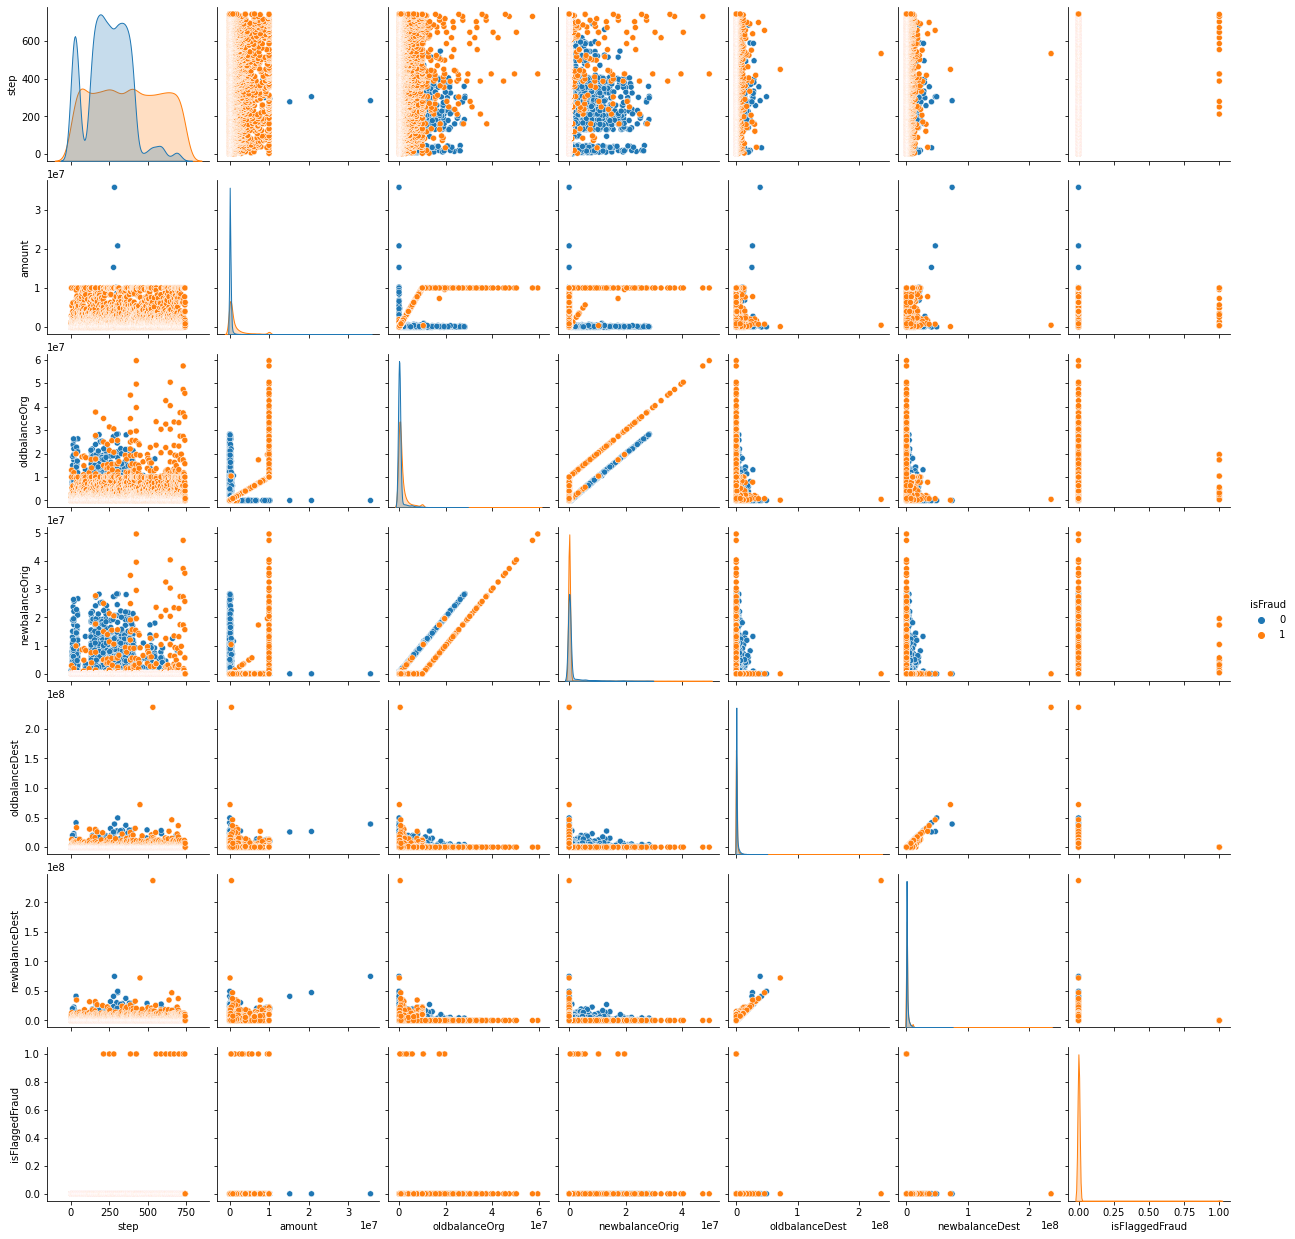

In [27]:
sns.pairplot(balance_subset_cols,hue='isFraud')

Interestingly, fraud is uniformly distriubted over step (proxy for date) while non-fraudulent interactions are not. From the pair plot, we can also tell that the amount transferred in a fraudulent transaction never goes above 10M units of currency and is generally linearly proportional to the original balance in the account up to 10M (although there are a few exceptions to this). This is markedly different behavior compared to non-fraudulent transactions.

In [28]:
pd.crosstab(index=balanced_data_sample['type'],columns=balanced_data_sample['isFraud'])


isFraud,0,1
type,,
CASH_IN,1760,0
CASH_OUT,2918,4100
DEBIT,46,0
PAYMENT,2782,0
TRANSFER,691,4097


Fraud is limited to only two types of transactions, CASH_OUT and TRANSFER.

# Log transform of skewed numerical variables including only transaction types of transfer and cash out

In [29]:
fraud_types = ['CASH_OUT','TRANSFER']
fraud_types_balanced_data_sample = balanced_data_sample[balance_subset_cols.type.isin(fraud_types)]

In [30]:
#select columns to log transform. Add +0.0001 for zero values to avoid NaNs.
log_cols = ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']
fraud_types_balanced_data_sample[log_cols]=np.log10(fraud_types_balanced_data_sample[log_cols]+0.0001)

C:\Users\bwitt\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [31]:
fraud_types_balanced_data_sample

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1593012,156,CASH_OUT,5.504602,C175823242,-4.000000,-4.000000,C737979678,5.814014,5.987329,0,0
3982478,298,CASH_OUT,4.508669,C372933181,-4.000000,-4.000000,C816159219,5.312145,5.375563,0,0
6245658,596,TRANSFER,4.960136,C820213226,5.299962,5.034546,C676181225,6.344437,6.362003,0,0
2952048,230,CASH_OUT,3.913510,C1989855051,-4.000000,-4.000000,C857989056,5.132232,5.157715,0,0
4453935,323,CASH_OUT,5.625962,C1219582195,4.509673,-4.000000,C706676043,5.541488,5.886806,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,5.531073,C786484425,5.531073,-4.000000,C776919290,-4.000000,5.531073,1,0
6362616,743,TRANSFER,6.800126,C1529008245,6.800126,-4.000000,C1881841831,-4.000000,-4.000000,1,0
6362617,743,CASH_OUT,6.800126,C1162922333,6.800126,-4.000000,C1365125890,4.835620,6.804814,1,0
6362618,743,TRANSFER,5.929420,C1685995037,5.929420,-4.000000,C2080388513,-4.000000,-4.000000,1,0


C:\Users\bwitt\Anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


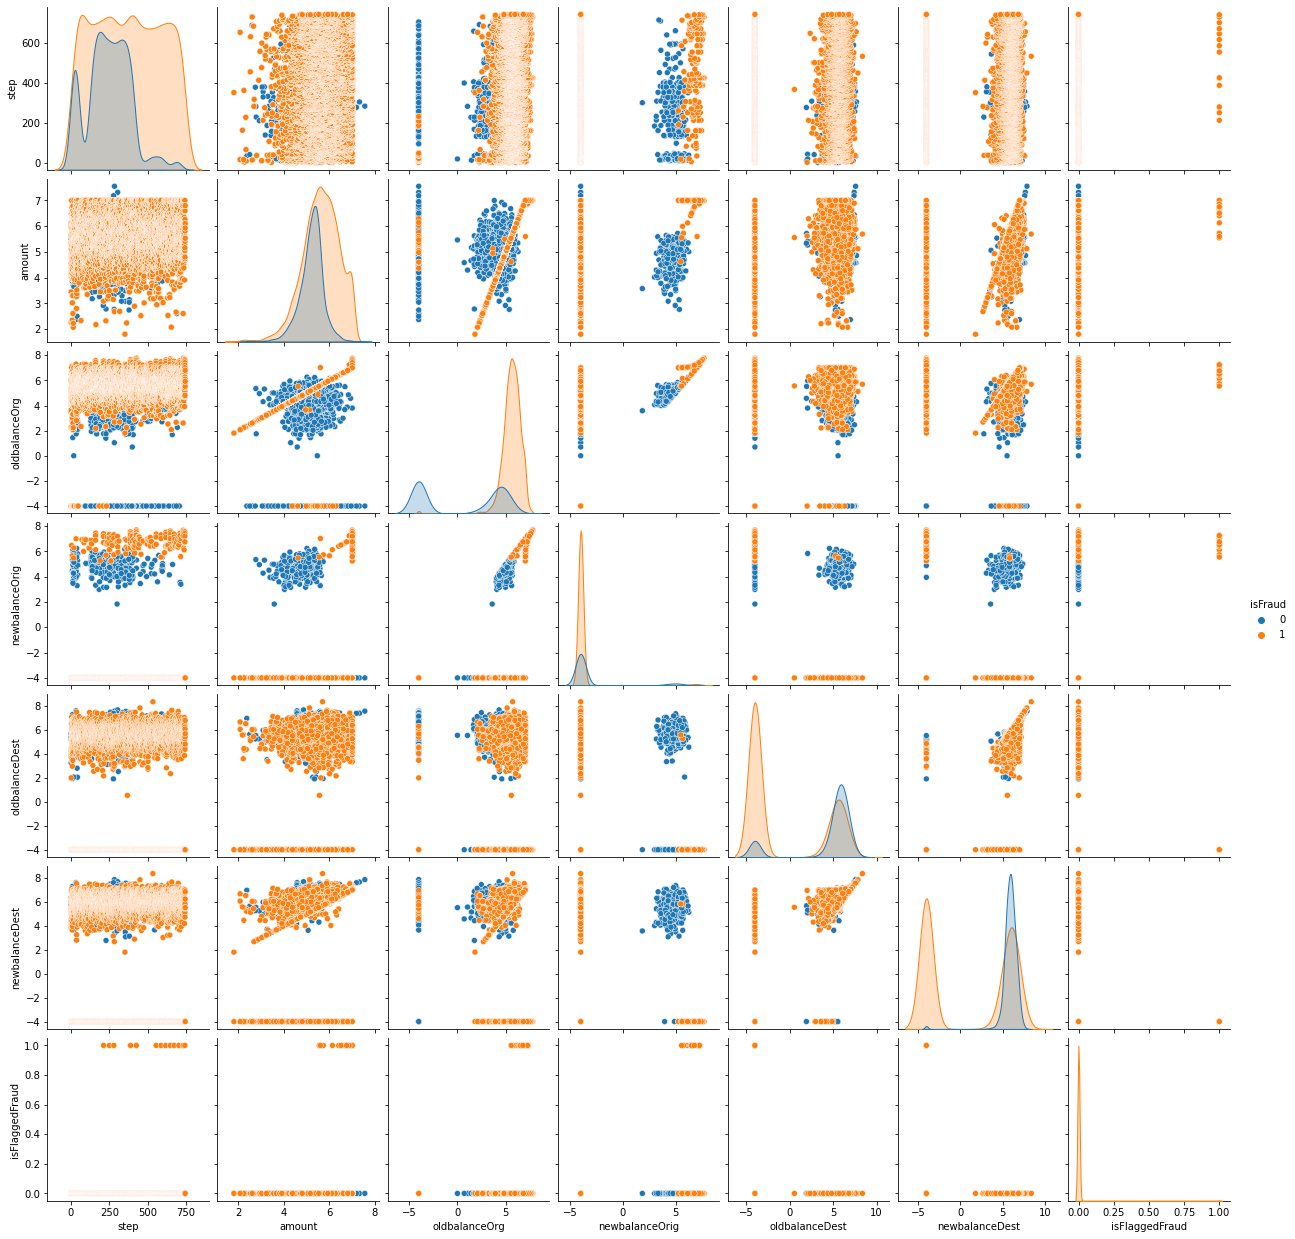

In [32]:
#does the picture change any if only fraud types are included?
sns.pairplot(fraud_types_balanced_data_sample,hue='isFraud')

From the above pair-plot, the most important features for fraud detection are step, amount, oldbalanceOrg, and newbalanceDest. However, additional feature engineering may be done, for example considering merchants vs. customers accounts. 

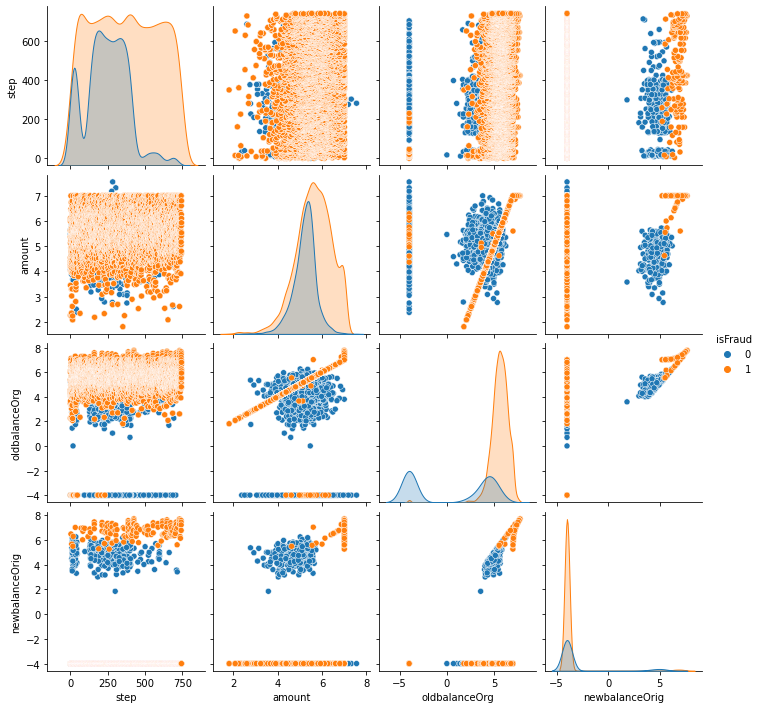

In [38]:
features = ['step','amount','oldbalanceOrg','newbalanceOrig','isFraud']
pp = sns.pairplot(fraud_types_balanced_data_sample[features],hue='isFraud')
